In [2]:
# pandas
import pandas as pd

# nltk for tokenization
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize

# spacy for entity rec
import spacy

In [2]:
nlp = spacy.load('en_core_web_sm')

In [3]:
'''
Read in .txts/.csvs of tagged sample data as a Pandas data frame
Add appropriate header to the columns as well.
'''
def read_as_df(buckets_filename, claim_id_filename, passage_filename):
    claim_ids = pd.read_csv(claim_id_filename, sep="\n")
    buckets = pd.read_csv(buckets_filename, sep="\n")
    passages = pd.read_csv(passage_filename, sep="\n")
    df_col_merged = pd.concat([claim_ids, buckets, passages], axis=1)

    return df_col_merged

In [4]:
merged = read_as_df('data/relic_prev_buckets.txt', 'data/relic_prev_ids.csv', 'data/relic_prev_passages.txt')

In [5]:
merged.head()

,claim_id,bucket,passage
0,13861,metaphor,The work of one moment was destroyed by the next.
1,55809,metaphor,How should they learn the entry into the finer...
2,3193,x,What is the meaning of life?
3,18123,internal character experience,His mind pictured the soldiers who would place...
4,18448,embellishing an event,He yelled then with fright and swung about. Fo...


In [6]:
def get_word_count(passage):
    return len(word_tokenize(passage))

In [7]:
def get_sentence_count(passage):
    return len(sent_tokenize(passage))

In [8]:
def get_entity_count(passage):
    doc = nlp(passage)
    return len(doc.ents)

In [1]:
def detect_first_person_passage(passage):
    passage_words = word_tokenize(passage)
    return "I" in passage_words or "me" in passage_words

In [ ]:
detect_first_person

In [9]:
# tally word count for each passage
merged['word_count'] = merged.apply(lambda x: get_word_count(x.passage), axis=1)

In [10]:
# tally sentence count for each passage
merged['sentence_count'] = merged.apply(lambda x: get_sentence_count(x.passage), axis=1)

In [11]:
# tally named entity count for each passage
merged['named_entity_count'] = merged.apply(lambda x: get_entity_count(x.passage), axis=1)

In [12]:
# word count per group
merged.groupby(['bucket'])['word_count'].median()

bucket
embellishing an event            44.0
external characterization        45.0
informative detail               45.0
internal character experience    41.0
metaphor                         40.0
sensory detail                   58.0
x                                33.5
Name: word_count, dtype: float64

In [13]:
# 5th percentile
merged['word_count'].quantile(0.05)

13.0

In [14]:
# 95th percentile
merged['word_count'].quantile(0.95)

112.0

In [15]:
# entity count per group
merged.groupby(['bucket'])['named_entity_count'].mean()

bucket
embellishing an event            0.880383
external characterization        0.843636
informative detail               1.454861
internal character experience    0.494624
metaphor                         0.851282
sensory detail                   1.028571
x                                0.836066
Name: named_entity_count, dtype: float64

<AxesSubplot:>

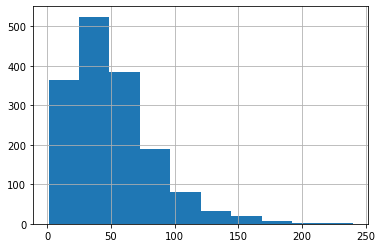

In [16]:
merged['word_count'].hist()

<AxesSubplot:>

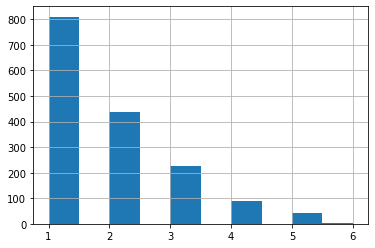

In [17]:
merged['sentence_count'].hist()

In [18]:
# sentence count per group
merged.groupby(['bucket'])['sentence_count'].mean()

bucket
embellishing an event            1.909091
external characterization        1.829091
informative detail               1.826389
internal character experience    1.854839
metaphor                         1.610256
sensory detail                   1.909524
x                                1.885246
Name: sentence_count, dtype: float64

In [19]:
merged.sort_values(by=['word_count'], ascending=False).head(30)[['passage', 'word_count']]

,passage,word_count
1281,"Natásha's illness was so serious that, fortuna...",240
376,then you saw a lifeboat full of children with ...,239
914,In the hardest working part of Coketown; in th...,207
1559,It may be that he pursues her doggedly and ste...,191
768,"it passed thus close by me, in action, so to s...",190
1499,"Meagre and spare, like all the other rooms, it...",188
1241,At first he had appreciated only the material ...,186
1292,My depression was not alleviated by the announ...,186
629,"After the first glance, there were slight feat...",179
761,"secondly, if it should appear that the conditi...",178


In [20]:
list(merged[merged['word_count'] < 13.0]['passage'])

['The work of one moment was destroyed by the next.',
 'What is the meaning of life?',
 'Carrie realised the change of affectional atmosphere at once.',
 'I am tied down with single words.',
 'A display!',
 'but spectral, not really existing.',
 'WHY should human equality be averted?',
 "It wasn't a scene for a shudder;",
 'A bird twittered; two birds, three.',
 'x',
 'The verdict of human nature on such a wretch was death.',
 'She possessed eyes whose gaze I delighted to encounter.',
 'It most froze me to hear such talk.',
 'All men live enveloped in whale-lines.',
 'I opened the glass-door in the breakfast-room:',
 'Winston stopped writing, partly because he was suffering from cramp.',
 'Sailors loiter on the parade, and amorous couples;',
 'She had thought him just the bright reflex of herself.',
 'Would they but love her, she should be satisfied.',
 'All here is false; all is meretricious.',
 'he is a tyrant; he wears Mrs. Ramsay to death;',
 "it's Cana of Galilee, the first miracl

In [22]:
len(list(merged[merged['word_count'] > 112]['claim_id']))

80